In [19]:
#bibliotecas pandas de leitura de arquivos
import pandas as pd
#biblioteca do kmeans
from sklearn.cluster import KMeans
import numpy as np
#avaliar classificacao cluster
#from sklearn.metrics.cluster import adjusted_rand_score
#visualizar graficos
import matplotlib.pyplot as plt
#caracter 
import re
#countar os itens de uma lista
from collections import Counter
#separar treino, teste, validação
from sklearn.model_selection import train_test_split
# métricas de avaliação do K-Means
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
# Método Silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import math
from sklearn import svm

from IPython.display import Image
from pathlib import Path


In [20]:
# Definição de diretórios e Disco de leitura dos arquivos (Desktop ou Notebook) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIR_BASE = DIR_PREFIXO / "Projeto_PA" / "dataset_modificado"
DIR_KMEANS = DIRETORIO_PRINCIPAL / "KMeansRandom"


In [21]:
#leitura do dataset completo com dados cadastrais, medidas e estatísticas
dataset = pd.read_csv(DIRETORIO_PRINCIPAL / "padrao_doenca" / "classificados_por_padroes_de_doenca_estatistica.csv",sep=';')
dataset_apos_tratamento = dataset

#dataset = dataset.drop ("Unnamed: 0", axis=1)
#for i in dataset.columns:
#    print(repr(i))
#

In [22]:
#converter peso em float

def Tratar_Peso(peso):    
    
    try:
        if peso[-1] == ',' or peso[-1] == '.':
            peso =  peso[:-1]
    except:
        pass
    
    
    try:
        peso = float(peso)
    except:
        peso = float(peso.replace(',','.'))
    return peso

#converter altura
def Tratar_Altura(altura):       
       
    
    if re.match('\d,,\d', altura):
        altura = altura.replace(',,','')
    
    try:
        if altura[-1] == ',' or altura[-1] == '.' or  altura[-1] == ']':
            altura =  altura[:-1]
    except:
        pass
    
    try:
        altura = float(altura)
    except:
        altura = float(altura.replace(',','.'))     
    
    # convt 150.00 para 1.50
    if altura >= 3:
        altura = altura/100 
    
    
    return altura

#calcular o IMC
def IMC(peso,altura):  
        
    imc = float(peso) / (float(altura) ** 2)
    
    return round (imc, 1)


#Trocar  True para 1 e False para 0
def verdadeiro_falso(valor):
    if valor == True:
        return 1
    else:
        return 0

def normaliza_float(n):
    if isinstance(n, (float, int)):
        return n
    if isinstance(n, str):
        if "," in n:
            n = n.replace(",", ".")
        if not n.replace(".", "").isdigit():
            n = "".join(digito for digito in n if digito in "0123456789.")
        n = n.replace("..", ".")
        if not n or n.count(".") > 1:
            n = float("nan")
         # convt 150.00 para 1.50
        n = float(n)
        if n >= 3:
            while 1:
                if (n//10 == 0.0 or n//10 == 0):
                    break
                else:
                    n = n/10 
    return float(n)

## Interpolação

(5, 145.0)

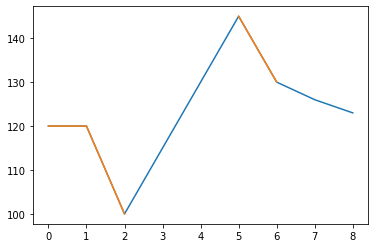

In [23]:
# Para calcular Mediana, AUC e AUC PP é preciso que os valores NaNs sejam tratados, pois do contrário
# o cálculo não é realizado. 
# Aqui tem as funções para interpolar as medidas faltantes e desenhar uma reta entre os pontos. E, é preciso 
# tratar de forma diferente os NanS da 1a. e última coluna.
# Com esses valores preenchidos, é possível calcular a AUC
#

def olha_pra_tras(linha, indice):
    """devolve o último índice e  valores válidos, antes do indice recebido """
    indice = indice - 1

    # pd.Series: precisa do iloc para funcionar com indices negativos
    while math.isnan(linha.iloc[indice]):
        indice -= 1
    return indice, linha.iloc[indice]

def olha_pra_frente(linha, indice):
    """devolve o próximo índice e  valores válidos, antes do indice recebido, "dando a volta" depois do último """
    indice = indice + 1

    # pd.Series: precisa do iloc para funcionar com indices negativos
    while math.isnan(linha.iloc[indice % len(linha)]):
        indice += 1
    return indice, linha.iloc[indice % len(linha)]


def interpola_sem_as_pontas(linha):
    """Dada uma ou mais medidas contendo NaN, interpola
    valores ligando uma reta entre as medidas imediatamente
    anterior e posterior à lacuna
    """
    linha = linha.copy()
    inicio_lacuna = None
    ultimo_valor_valido = None
    ultimo_indice_valido = None
    valor_anterior = 0
    

    
    for indice, valor in enumerate(linha):
        if math.isnan(valor):
            if indice == 0:
                # caso especial - tem que interpolar com valores de antes das 9h00
                pass
            elif inicio_lacuna is not None:
                pass
            else:
                # Primeiro NaN em uma lacuna
                ultimo_valor_valido = valor_anterior
                ultimo_indice_valido = indice - 1
                inicio_lacuna = indice
        elif inicio_lacuna is not None:
            # primeiro número encontrado após uma lacuna
            b = ultimo_valor_valido
            a = (valor - ultimo_valor_valido) / (indice - ultimo_indice_valido)
            for j in range(ultimo_indice_valido + 1, indice):
                x = j - ultimo_indice_valido
                linha[j] = a * x + b
                
            
            inicio_lacuna = None
            ultimo_indice_valido = None
                
        valor_anterior = valor
        # para fazer: se termina a linha dentro de uma lacuna
    return linha

def interpola_lacuna(linha, indice_anterior, valor_valido_anterior, indice, valor):
    b = valor_valido_anterior
    a = (valor - b) / (indice - indice_anterior)
    for j in range(indice_anterior + 1, indice):
        x = j - indice_anterior
        linha[j % len(linha)] = int(a * x + b)

def interpola(linha):
    """Dada uma ou mais medidas contendo NaN, interpola
    valores ligando uma reta entre as medidas imediatamente
    anterior e posterior à lacuna
    """
    linha = linha.copy()
    inicio_lacuna = None
    ultimo_valor_valido = None
    ultimo_indice_valido = None
    valor_anterior = 0
    
    for indice, valor in enumerate(linha):
        if math.isnan(valor_anterior) and not math.isnan(valor):
            indice_anterior, valor_valido_anterior = olha_pra_tras(linha, indice)
            interpola_lacuna(linha, indice_anterior, valor_valido_anterior, indice, valor)
            
        valor_anterior = valor
            
    # para fazer: se termina a linha dentro de uma lacuna
    if math.isnan(valor):
        # se o ultimo valor é um nan - o dia acaba dentro de uma lacuna:
        indice, valor = olha_pra_tras(linha, indice)
        
        proximo_indice, proximo_valor = olha_pra_frente(linha, indice)
        interpola_lacuna(linha, indice, valor, proximo_indice, proximo_valor)
        
    return linha
            
    
v1 = pd.Series([120, 120, 100, math.nan, math.nan, 145, 130, math.nan, math.nan])
v2 = interpola(v1)
plt.plot(v2.index, v2)
plt.plot(v1.index, v1)

olha_pra_frente(v1, 4)


In [24]:
#   Identifica os campos de Sist e Diast e aplica a função "Interpola"
dataset_apos_tratamento.loc[:,'sist 9:00':'sist 8:45'] = dataset_apos_tratamento.loc[:,'sist 9:00':'sist 8:45'].apply(interpola, axis=1)
dataset_apos_tratamento.loc[:,'diast 9:00':'diast 8:45'] = dataset_apos_tratamento.loc[:,'diast 9:00':'diast 8:45'].apply(interpola, axis=1)

dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45'].head()

,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
0,105.0,108.0,116.0,104.0,106.0,98.0,102.0,107.0,111.0,116.0,...,41.0,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0
1,103.0,114.0,82.0,104.0,98.0,106.0,108.0,107.0,109.0,100.0,...,74.0,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0
2,147.0,148.0,156.0,140.0,130.0,132.0,121.0,113.0,149.0,128.0,...,80.0,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0
3,140.0,139.0,142.0,137.0,135.0,177.0,148.0,152.0,135.0,136.0,...,49.0,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0
4,113.0,110.0,101.0,108.0,111.0,111.0,114.0,115.0,113.0,112.0,...,64.0,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0


In [25]:
# Identificando dados espúrios no campo altura e descartando
dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['altura'] != '?']

#filtrar nulos em peso e altura
dataset_apos_tratamento = dataset_apos_tratamento[~dataset_apos_tratamento['peso'].isnull() & ~dataset_apos_tratamento['altura'].isnull()]

In [26]:
#  Normalizando Peso e Altura
dataset_apos_tratamento['peso_normalizado'] = dataset_apos_tratamento['peso'].apply(Tratar_Peso)
dataset_apos_tratamento['altura_normalizada'] = dataset_apos_tratamento['altura'].apply(normaliza_float)

In [27]:
#max(dataset_apos_tratamento['peso_normalizado'])
#max(dataset_apos_tratamento['altura_normalizada'].values)


In [28]:
#calculo do IMC
# Inclui coluna de IMC no dataset de entrada
dataset_apos_tratamento['IMC'] = dataset_apos_tratamento.apply(lambda row : IMC(row['peso_normalizado'], row['altura_normalizada']), axis = 1)

In [29]:
dataset_apos_tratamento = dataset_apos_tratamento[(dataset_apos_tratamento['idade'] != 0) & (dataset_apos_tratamento['peso_normalizado'] <= 200)]
dataset_apos_tratamento

,numero_identificacao,data_nascimento,genero,idade,peso,altura,data_exame,sist 9:00,sist 9:15,sist 9:30,...,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Diferenca % Dipping,Picos Sistolica,Picos Diastolica,peso_normalizado,altura_normalizada,IMC
0,4,1923-10-05,M,94.0,85.0,160,2018-09-10 12:25:23,105.0,108.0,116.0,...,3748.0,841.5,16.52,11.36,0.966,11,34,85.0,1.60,33.2
1,5,1948-10-07,M,70.0,80.0,165,2018-12-26 07:39:41,103.0,114.0,82.0,...,2915.0,606.0,7.51,6.65,0.969,9,23,80.0,1.65,29.4
2,6,1999-03-23,M,19.0,100.0,197,2018-12-26 08:06:19,147.0,148.0,156.0,...,3721.0,751.5,12.70,13.01,1.056,19,19,100.0,1.97,25.8
3,7,1978-01-26,F,40.0,65.0,"1,64",2018-12-26 08:19:06,140.0,139.0,142.0,...,3642.0,602.5,16.13,10.34,1.107,21,9,65.0,1.64,24.2
4,8,1990-03-07,M,28.0,120.0,172,2018-12-26 08:26:59,113.0,110.0,101.0,...,2405.0,566.0,12.27,12.79,1.137,10,11,120.0,1.72,40.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19556,21786,1972-11-25,M,47.0,75.0,165,2020-09-10 16:03:08,163.0,198.0,172.0,...,2439.0,474.5,18.66,14.80,1.134,49,60,75.0,1.65,27.5
19557,21787,1970-10-19,M,49.0,90.0,183,2020-09-10 16:21:02,114.0,120.0,164.0,...,3319.0,738.0,17.22,13.67,1.046,32,27,90.0,1.83,26.9
19558,21788,1985-03-15,F,35.0,93.0,167,2020-09-10 16:44:53,107.0,110.0,103.0,...,3556.0,713.5,14.36,8.29,1.029,14,26,93.0,1.67,33.3
19559,21792,1952-04-21,F,68.0,64.0,160,2020-09-10 17:25:50,94.0,107.0,112.0,...,2815.5,460.0,14.14,9.38,1.252,19,13,64.0,1.60,25.0


In [30]:
#dataset_apos_tratamento[(dataset_apos_tratamento['idade'] == 0) & (dataset_apos_tratamento['altura'] < 80)]
pesos = dataset_apos_tratamento[(dataset_apos_tratamento['idade'] != 0) & (dataset_apos_tratamento['peso_normalizado'] <= 200)]['peso_normalizado'].unique()
pesos.sort()
pesos

array([  4.,   6.,  22.,  24.,  30.,  31.,  33.,  35.,  36.,  37.,  38.,
        39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,
        50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
        72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       116., 117., 118., 119., 120., 121., 122., 123., 124., 125., 126.,
       127., 128., 129., 130., 132., 133., 134., 135., 136., 137., 138.,
       139., 140., 142., 143., 145., 146., 147., 148., 149., 150., 151.,
       152., 153., 154., 155., 156., 157., 158., 159., 160., 161., 162.,
       163., 164., 165., 166., 167., 168., 169., 170., 171., 173., 174.,
       175., 176., 177., 178., 180., 181., 182., 18

In [31]:
# transform Gender M and F to binary 

limpa_coluna_genero = {"genero": {"M": True, "F": False}}
controle = 1
genero0 = dataset['genero']
for i in range(len(genero0)):
    if genero0.iloc[i] != 'M' and genero0.iloc[i] != 'F':
        if controle == 1:
            genero0.iloc[i] = 0
            controle = 0
        else:
            genero0.iloc[i] = 1
            controle = 1

dataset_apos_tratamento['genero'] = genero0

dataset_apos_tratamento = dataset_apos_tratamento.replace(limpa_coluna_genero)

dataset_apos_tratamento["genero"] = dataset_apos_tratamento["genero"].astype(int)

limpa_coluna_genero = {"genero": {"M": True, "F": False}}
#
#


In [32]:
dataset_apos_tratamento['idade'] = dataset_apos_tratamento['idade'].fillna(-1)
dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['idade'] != -1]

In [33]:
dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['altura_normalizada'] <= 2.5]
dataset_apos_tratamento = pd.concat([dataset_apos_tratamento.loc[:,'numero_identificacao':'altura'],
                                     dataset_apos_tratamento['IMC'],
                                    dataset_apos_tratamento.loc[:,'data_exame':'Picos Diastolica']],
                                    axis=1)

print(len(dataset_apos_tratamento))
# Dataset com IMC e tratamento de Nans com a política de normalização
dataset_apos_tratamento.to_csv(DIR_BASE / "pacientes_completos_tratados.csv", 
                        sep=";", encoding="latin1", index=False)

dataset_apos_tratamento.to_csv(DIR_BASE / "pacientes_com_tab.csv", 
                        sep="\t", encoding="latin1", index=False)

19242
